In [9]:
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mticker
from dotenv.main import load_dotenv
import os

load_dotenv(override=True)

True

## Plotting compliance

You can choose between plotting average portfolio in each portfolio, or all of them.

In [10]:
df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0)
df.index = pd.to_datetime(df.index)

In [11]:
frac_liabilities = float(os.getenv('FRAC_LIABILITIES'))

In [12]:
def load_pareto_fronts(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
    
    all_runs = []
    for entry in data:
        pareto_front = []
        for solution in entry.get("solutions", []):
            # Ensure solution is a dictionary
            if isinstance(solution, dict):
                pareto_front.append({
                    "weights": solution.get("weights", []),
                    "expected_return": solution.get("expected_return", 0),
                    "SCR_risk": solution.get("SCR_risk", 0),
                    "risk_measure": solution.get("risk_measure", ""),
                    "distribution": solution.get("distribution", ""),
                    "period": solution.get("period", [])
                })
        all_runs.append(pareto_front)
    return all_runs

json_file_path = "../pareto_front_results.json"
pareto_fronts = load_pareto_fronts(json_file_path)
len(pareto_fronts[0])

100

In [13]:
def average_weights_pareto_fronts(pareto_fronts):
    averaged_pareto_fronts = []

    for pareto_front in pareto_fronts:
        # Extract all weights from the solutions in the Pareto front
        all_weights = np.array([solution["weights"] for solution in pareto_front])
        
        if len(all_weights) > 0:  # Ensure there are solutions to average
            # Compute the average weights
            avg_weights = np.mean(all_weights, axis=0)
        else:
            avg_weights = []

        # Create a new Pareto front with averaged weights
        averaged_pareto_front = []
        solution = pareto_front[0]
        new_solution = solution.copy()
        new_solution["weights"] = avg_weights.tolist()  # Convert numpy array back to list
        averaged_pareto_front.append(new_solution)
        
        averaged_pareto_fronts.append(averaged_pareto_front)

    return averaged_pareto_fronts


In [14]:
def risk_averse_portfolios(pareto_fronts):
    risk_averse_portfolios = []

    for pareto_front in pareto_fronts:

        portfolio = min(pareto_front, key=lambda portfolio: portfolio['SCR_risk'])
        least_risk_portfolio = [portfolio]
        risk_averse_portfolios.append(least_risk_portfolio)
    return risk_averse_portfolios

In [15]:
pareto_fronts1 = average_weights_pareto_fronts(pareto_fronts)
pareto_fronts = risk_averse_portfolios(pareto_fronts)

print(pareto_fronts)

print(pareto_fronts1)

[[{'weights': [0.06379707978285105, 0.026116632181481116, 0.06700957736392994, 0.18443618774710277, 0.29088880644725473, 0.05830718303850742, 0.30944859161480737], 'expected_return': 38573.57323538467, 'SCR_risk': 220458.69914267238, 'risk_measure': 'cvar', 'distribution': 'tstudent', 'period': ['2021-11-01', '2022-11-01']}], [{'weights': [0.09949810496375998, 0.10615266283377654, 0.13570473507478883, 0.225700368319664, 0.2596158488143521, 0.16870835305547813, 0.004627427012984443], 'expected_return': 64931.676983048106, 'SCR_risk': 102425.05974326438, 'risk_measure': 'var', 'distribution': 'normal', 'period': ['2021-11-01', '2022-11-01']}], [{'weights': [0.09812703528981169, 0.008073324042662703, 0.07809737981665062, 0.4041021826807362, 0.23345639823927994, 0.12200090035113632, 0.056229744094392825], 'expected_return': 50256.108714472, 'SCR_risk': 68260.60387920766, 'risk_measure': 'cvar', 'distribution': 'normal', 'period': ['2021-11-01', '2022-11-01']}], [{'weights': [0.164054394055

--------------NEW PARETO FRONT--------------
Compliance = 0.6889334348208512
SCR = 220458.69914267238
Configuration: CVaR with t-Student


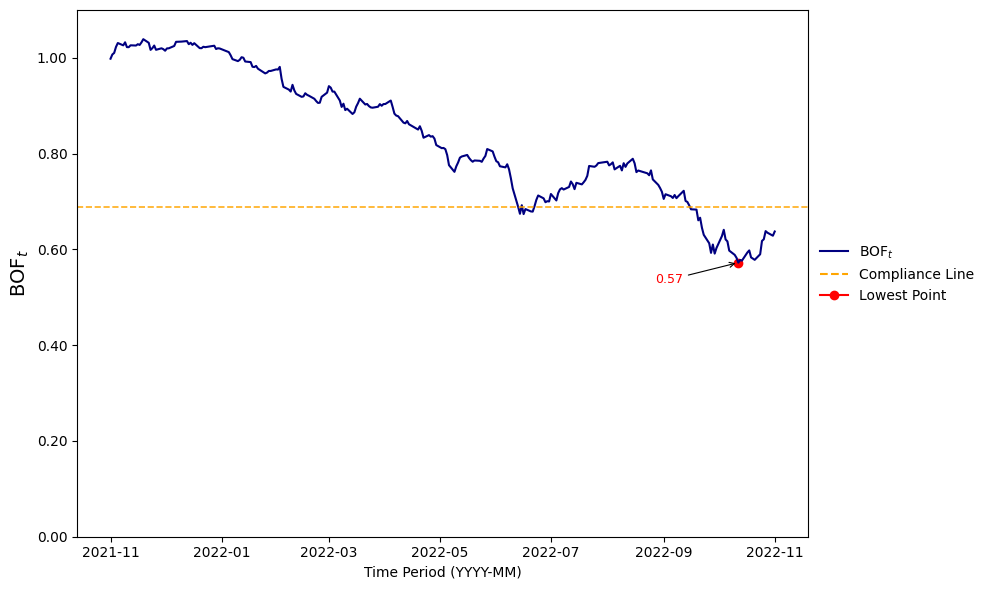

--------------NEW PARETO FRONT--------------
Compliance = 0.3200783116977012
SCR = 102425.05974326438
Configuration: VaR with Gaussian


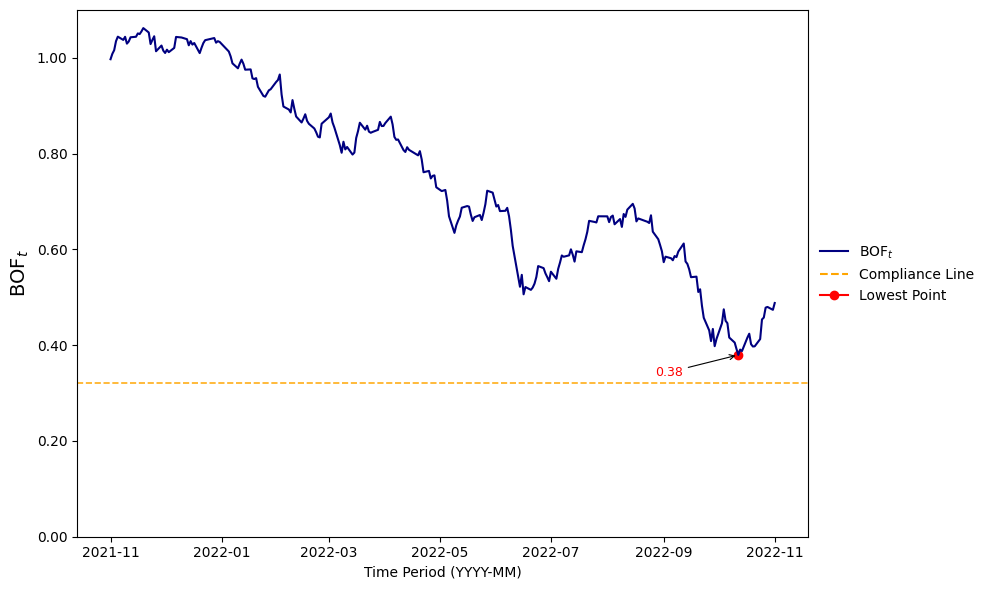

--------------NEW PARETO FRONT--------------
Compliance = 0.21331438712252393
SCR = 68260.60387920766
Configuration: CVaR with Gaussian


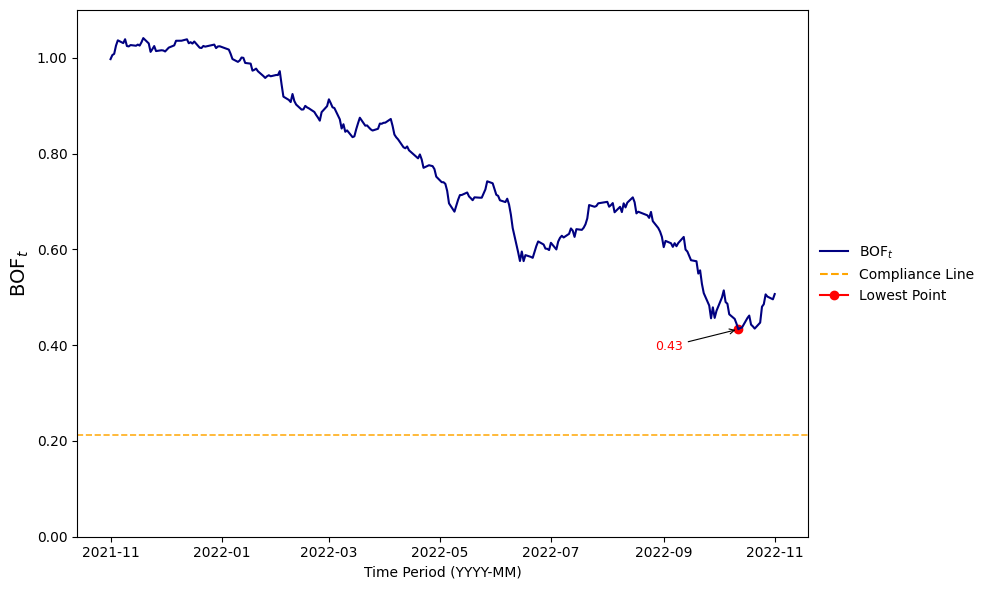

--------------NEW PARETO FRONT--------------
Compliance = 0.5633576025312773
SCR = 180274.43281000873
Configuration: VaR with t-Student


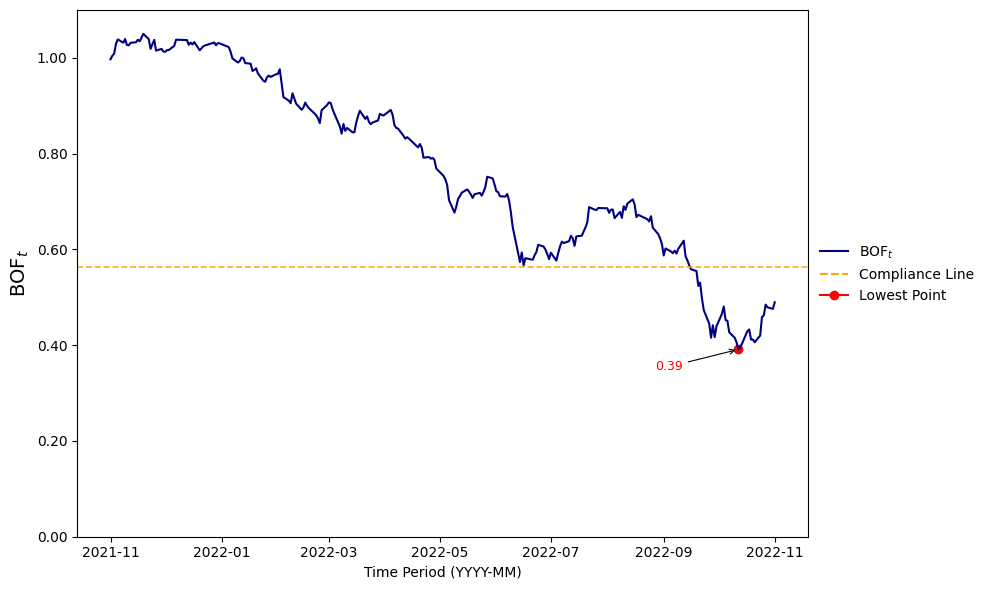

--------------NEW PARETO FRONT--------------
Compliance = 0.12878579126629397
SCR = 41211.45320521407
Configuration: CVaR with t-Student


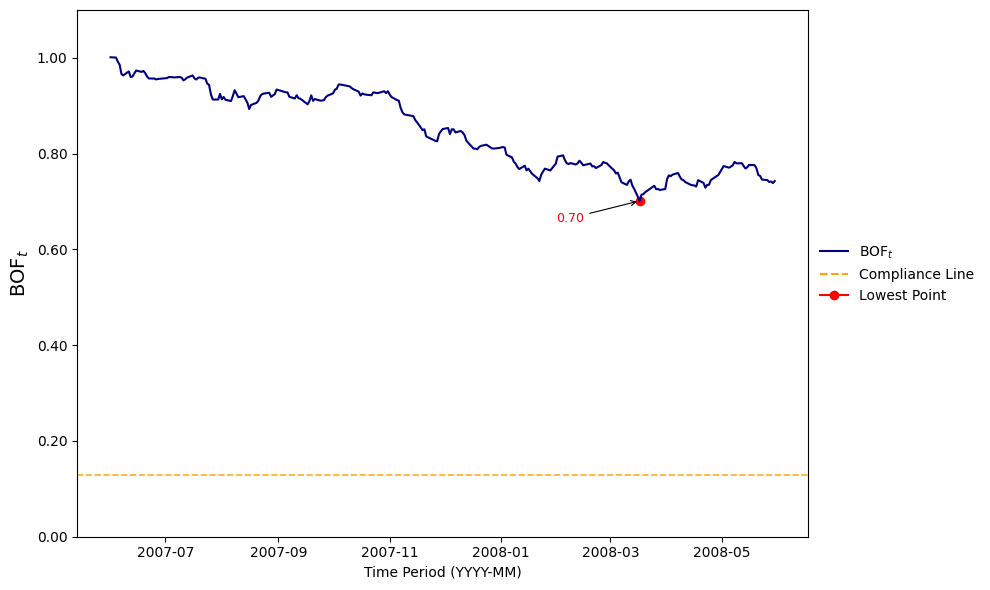

--------------NEW PARETO FRONT--------------
Compliance = 0.09420375561396684
SCR = 30145.201796469388
Configuration: VaR with Gaussian


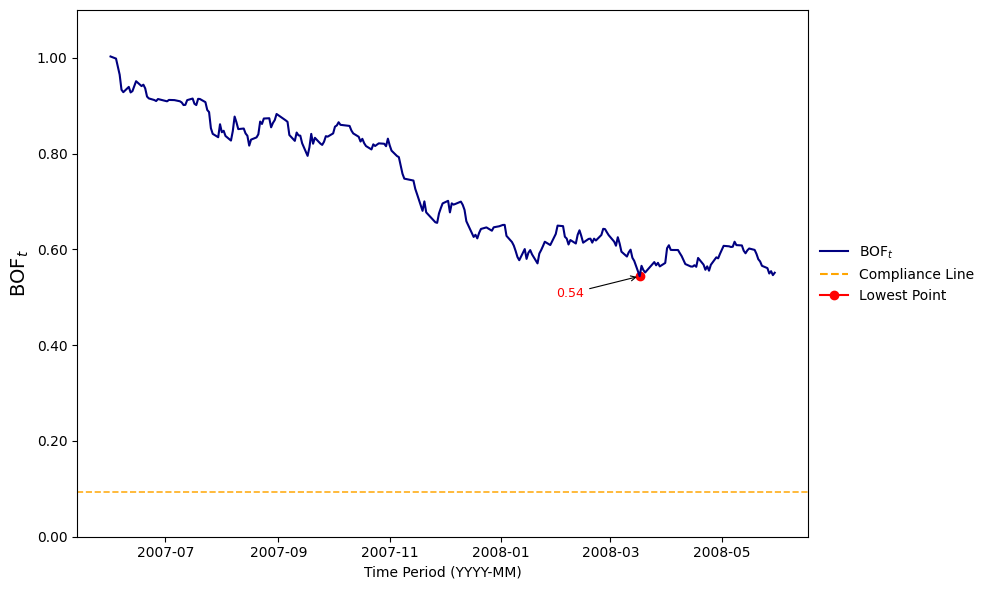

--------------NEW PARETO FRONT--------------
Compliance = 0.13394015553817126
SCR = 42860.8497722148
Configuration: CVaR with Gaussian


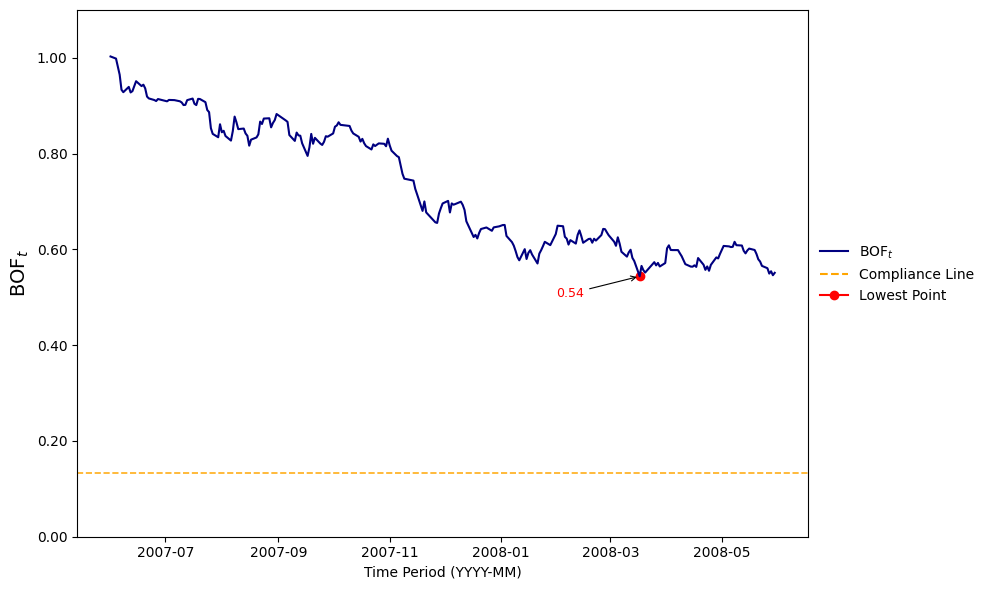

--------------NEW PARETO FRONT--------------
Compliance = 0.20738081674386336
SCR = 66361.86135803627
Configuration: VaR with t-Student


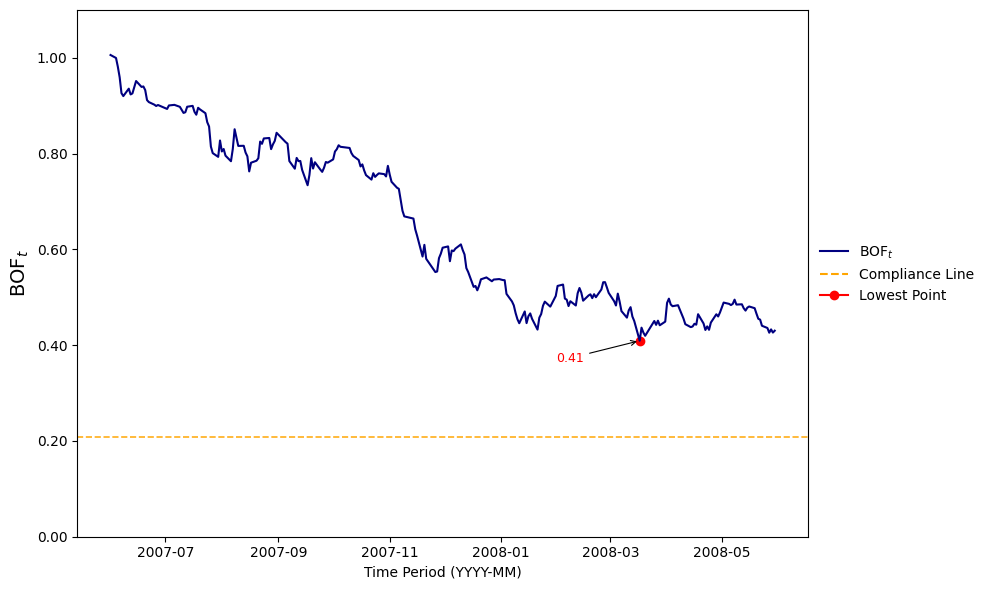

--------------NEW PARETO FRONT--------------
Compliance = 0.9604770997210286
SCR = 307352.67191072914
Configuration: CVaR with t-Student


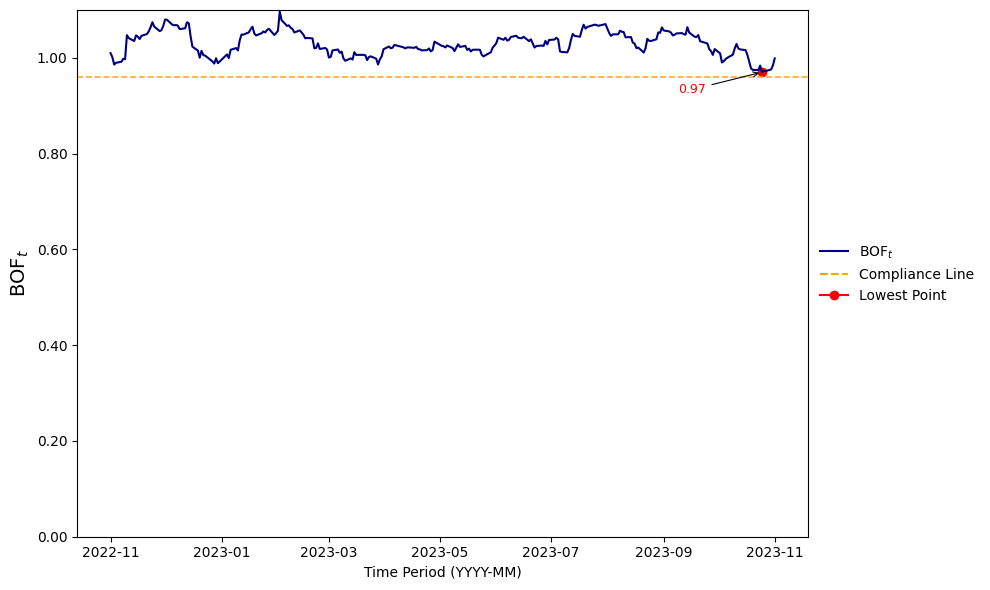

--------------NEW PARETO FRONT--------------
Compliance = 0.1580480857519979
SCR = 50575.38744063933
Configuration: VaR with Gaussian


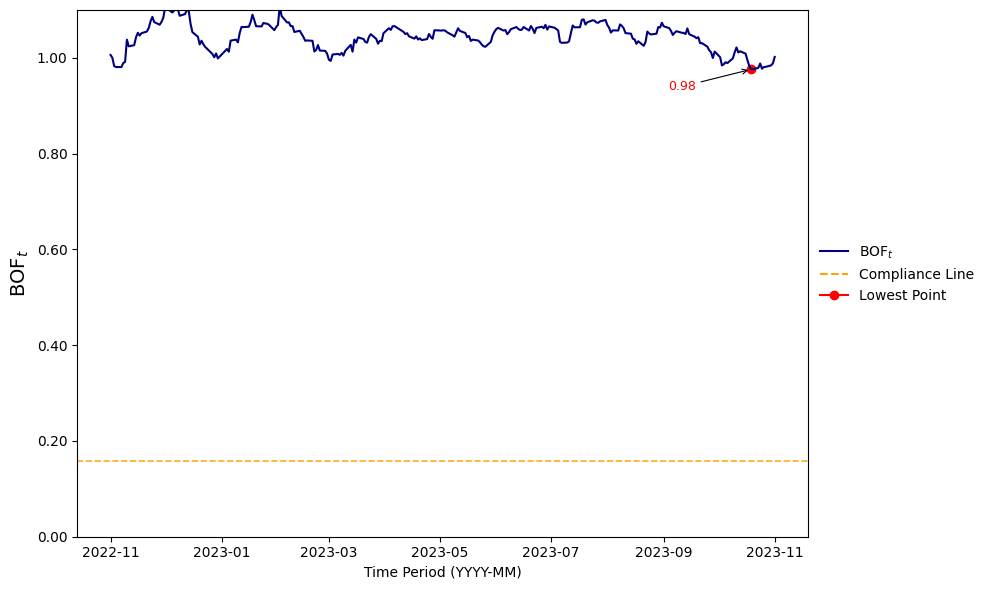

--------------NEW PARETO FRONT--------------
Compliance = 0.19088281249269654
SCR = 61082.49999766289
Configuration: CVaR with Gaussian


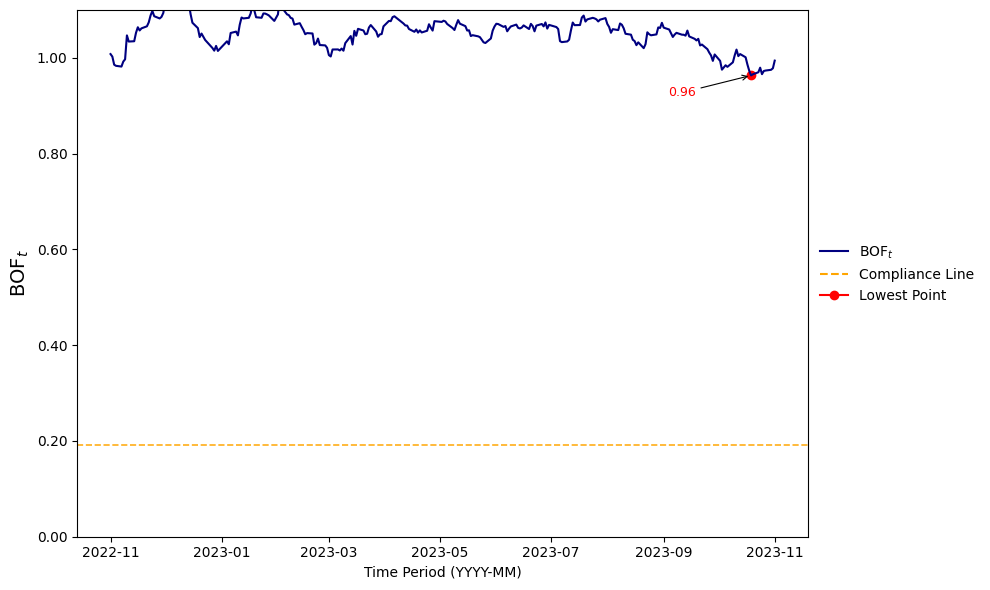

--------------NEW PARETO FRONT--------------
Compliance = 0.5934009442025581
SCR = 189888.3021448186
Configuration: VaR with t-Student


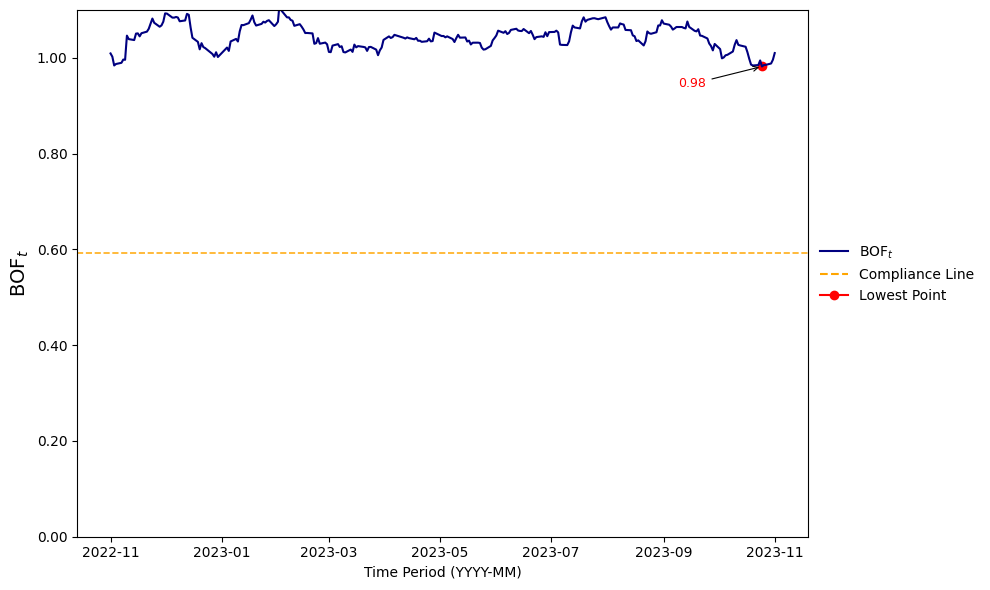

In [16]:
for pareto_front in pareto_fronts:
    print("--------------NEW PARETO FRONT--------------")
    i = 0
    for portfolio in pareto_front:
        i += 1
        bof_changes = []

        weights = portfolio["weights"]
        period = portfolio["period"]
        start_date = pd.to_datetime(
            period[0], format='%Y-%m-%d', errors='coerce')
        end_date = pd.to_datetime(
            period[1], format='%Y-%m-%d', errors='coerce')

        filtered_df = df[(df.index >= str(start_date))
                         & (df.index <= str(end_date))]

        assets_0 = 1000000
        liabilities_0 = assets_0 * frac_liabilities

        for current_date in filtered_df.index:
            current_data = filtered_df.loc[:current_date]

            stock_returns = current_data
            eonia_returns = current_data["EONIA"]
            portfolio_returns = np.dot(stock_returns.values, weights)
            cumulative_portfolio_return = np.prod(1 + portfolio_returns) - 1

            cumulative_liability_growth = np.prod(1 + eonia_returns) - 1

            bof_1 = ((1 + cumulative_portfolio_return) * assets_0) - \
                ((1+cumulative_liability_growth) * liabilities_0)


            bof_t = bof_1 / (assets_0 - liabilities_0)

            bof_changes.append({
                "time": current_date,
                "final_bof": bof_t,
                "risk_measure": portfolio["risk_measure"]
            })

        bof_changes_df = pd.DataFrame(bof_changes)

        plt.figure(figsize=(10, 6))
        plt.plot(
            bof_changes_df["time"],
            bof_changes_df["final_bof"],
            color="navy", linewidth=1.5, label=r"$\Delta$ BOF_t"
        )

        min_bof_index = bof_changes_df["final_bof"].idxmin()
        min_bof_value = bof_changes_df.loc[min_bof_index, "final_bof"]
        min_bof_time = bof_changes_df.loc[min_bof_index, "time"]

        plt.scatter(min_bof_time, min_bof_value,
                    color="red", label="Lowest Point")
        plt.annotate(
            f"{min_bof_value:,.2f}",
            (min_bof_time, min_bof_value),
            textcoords="offset points",
            xytext=(-50, -15),
            ha='center',
            fontsize=9,
            color="red",
            arrowprops=dict(facecolor='red', arrowstyle="->", lw=0.8)
        )

        compliance = portfolio['SCR_risk'] / (assets_0 - liabilities_0)
        print("Compliance =", compliance)
        plt.axhline(compliance, color="orange", linestyle="--", linewidth=1.2, alpha=0.9, label="Compliance Line")
        print(f"SCR = {portfolio['SCR_risk']}")

        plt.ylim(0, 1.1)
        plt.gca().yaxis.set_major_formatter(
            mticker.StrMethodFormatter('{x:,.2f}'))

        info_text = "\n".join([f"{key}: {value}" for key, value in portfolio.items(
        ) if key not in ["weights", "expected_return", "period"]])
        
        risk_measure_mapping = {
            "var": "VaR",
            "cvar": "CVaR"
        }

        distribution_mapping = {
            "normal": "Gaussian",
            "tstudent": "t-Student"
        }

        info = {
            "Risk Measure": risk_measure_mapping.get(portfolio["risk_measure"].lower(), portfolio["risk_measure"]),
            "Distribution": distribution_mapping.get(portfolio["distribution"].lower(), portfolio["distribution"])
        }

        info_legend_text = "\n".join(
            [f"{key}: {value}" for key, value in info.items()])

        plt.legend(
            handles=[
                plt.Line2D([], [], color='navy', label=r"$\text{BOF}_t$"),
                plt.Line2D([], [], color='orange', linestyle="--",
                           label="Compliance Line"),
                plt.Line2D([], [], color='red', marker='o',
                           label="Lowest Point")
            ],
            loc='center left', 
            bbox_to_anchor=(1, 0.5),
            frameon=False,
            fontsize=10
        )

        title_text = f"Configuration: {info['Risk Measure']} with {info['Distribution']}"

        
        plt.xlabel("Time Period (YYYY-MM)")
        plt.ylabel(r"$\text{BOF}_t$", size=14)
        #plt.title(title_text, size=14)
        print(title_text)
    
        plt.grid(False)
        plt.tight_layout()
        plt.show()